In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import math
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
# wandb.login(key="a3ab9e880247c3575c105c3a5abb88ebc2eba87a")

### Loading and Preprocessing data

In [3]:
data=pd.read_csv('HousingData.csv')
mean_cols=['CRIM','ZN','INDUS','AGE','LSTAT']
for col in mean_cols:
    mean_imputer = SimpleImputer(strategy='mean')
    data[col]=mean_imputer.fit_transform(data[[col]])
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
data['CHAS']=most_frequent_imputer.fit_transform(data[['CHAS']])
summary_stats = pd.DataFrame({
    "Mean": data.mean(),
    "Std": data.std(),
    "Min": data.min(),
    "Max": data.max()
})
print(summary_stats)

               Mean         Std        Min       Max
CRIM       3.611874    8.545770    0.00632   88.9762
ZN        11.211934   22.921051    0.00000  100.0000
INDUS     11.083992    6.699165    0.46000   27.7400
CHAS       0.067194    0.250605    0.00000    1.0000
NOX        0.554695    0.115878    0.38500    0.8710
RM         6.284634    0.702617    3.56100    8.7800
AGE       68.518519   27.439466    2.90000  100.0000
DIS        3.795043    2.105710    1.12960   12.1265
RAD        9.549407    8.707259    1.00000   24.0000
TAX      408.237154  168.537116  187.00000  711.0000
PTRATIO   18.455534    2.164946   12.60000   22.0000
B        356.674032   91.294864    0.32000  396.9000
LSTAT     12.715432    7.012739    1.73000   37.9700
MEDV      22.532806    9.197104    5.00000   50.0000


### Graph to show distribution of dependant variable

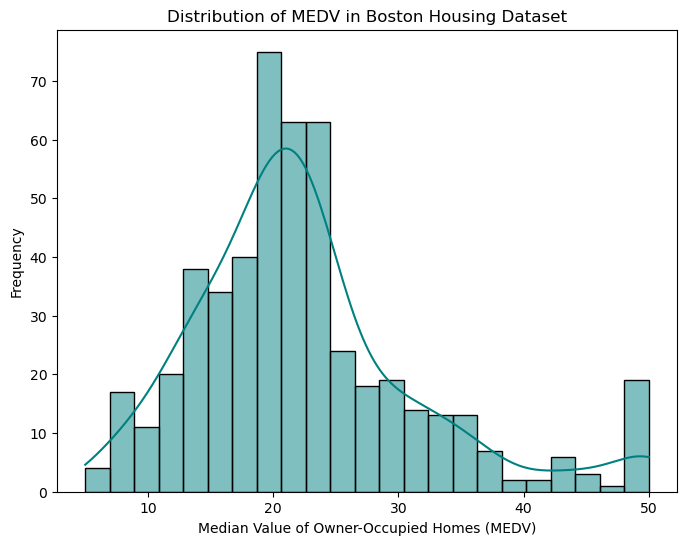

In [4]:
plt.figure(figsize=(8, 6))
sns.histplot(data['MEDV'], kde=True, color='teal')
plt.xlabel('Median Value of Owner-Occupied Homes (MEDV)')
plt.ylabel('Frequency')
plt.title('Distribution of MEDV in Boston Housing Dataset')
plt.show()

In [5]:
x=data.loc[:,~data.columns.isin(['MEDV'])].values
y=data['MEDV'].values
y=y.reshape(-1,1)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
scalar=StandardScaler()
scalar.fit(x_train)
x_train=scalar.transform(x_train)
x_val=scalar.transform(x_val)
x_test=scalar.transform(x_test)
minmax_scalar=MinMaxScaler()
minmax_scalar.fit(x_train)
x_train=minmax_scalar.transform(x_train)
x_val=minmax_scalar.transform(x_val)
x_test=minmax_scalar.transform(x_test)

In [6]:
class MLPRegressor:
    def __init__(self,learning_rate,activation_function,optimizer,num_hidden_layers,count_neurons):
        self.lrate=learning_rate
        self.activation_func=activation_function
        self.optimizer=optimizer
        self.hidden_layers=num_hidden_layers
        self.num_neurons=count_neurons
        self.input_layer_size=None
        self.weights=None
        self.biases=None
        self.batch_size=50
    def set_activation_function(self,af):
        self.activation_func=af
    def set_optimizer(self,opt):
        self.optimizer=opt
    def set_learning_rate(self,lr):
        self.lrate=lr
    def set_hidden_layers(self,hl):
        self.hidden_layers=hl
    def set_num_neurons(self,m):
        self.num_neurons=m
    def ReLu(self,z):
        return np.maximum(0,z)
    def Tanh(self,z):
        return (2/(1+np.exp(-2*z)))-1
    def Sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def linear(self, x):
        return x
    def init_weights_biases(self):
        weights=[]
        biases=[]
        for i in range(1,len(self.layer_sizes)):
            weight_matrix = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * math.sqrt(2.0/self.layer_sizes[i-1])
            bias_vector = np.zeros((1,self.layer_sizes[i]))
            weights.append(weight_matrix)
            biases.append(bias_vector)
        return weights, biases
    def forward_propagation(self,X):
        activations = [X]
        z_values = []
        for i in range(len(self.layer_sizes) - 1):
            z = activations[-1]@self.weights[i] + self.biases[i]
            a = self.Sigmoid(z) if i < len(self.layer_sizes) - 2 else self.linear(z)
            if self.activation_func=='tanh':
                a = self.Tanh(z) if i < len(self.layer_sizes) - 2 else self.linear(z)
            elif self.activation_func=='ReLu':
                a = self.ReLu(z) if i < len(self.layer_sizes) - 2 else self.linear(z)
            z_values.append(z)
            activations.append(a)
        return activations, z_values
    def backward_propagation(self,y,activations):
        grads = []
        delta = activations[-1] - y
        for i in range(len(self.layer_sizes) - 2, -1, -1):
            dw = 2/self.samples*activations[i].T@delta
            db = 2/self.samples*np.sum(delta, axis=0, keepdims=True)
            # dw = activations[i].T@delta
            # db = np.sum(delta, axis=0, keepdims=True)
            grads.append((dw, db))
            if i > 0:
                if self.activation_func=='sigmoid':
                    delta = (delta@self.weights[i].T) * activations[i] * (1 - activations[i])
                elif self.activation_func=='tanh':
                    delta=(delta@self.weights[i].T)*(1-np.square(activations[i]))
                elif self.activation_func=='ReLu':
                    delta=(delta@self.weights[i].T)*((activations[i]>0).astype(int))
        grads.reverse()
        return grads
    def compute_loss(self, y_true, y_pred):
        return np.sum((y_true - y_pred) ** 2)/self.samples
        # return np.sum((y_true - y_pred) ** 2)/2
    def update_parameters(self,grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lrate * grads[i][0]
            self.biases[i] -= self.lrate * grads[i][1]
    def train(self,x,y,num_epochs):
        # nm=f"lr:{self.lrate},epochs:{num_epochs}"
        nm=f"L:{self.hidden_layers},LS:{self.num_neurons},lr:{self.lrate}"
        # wandb.init(
        #     project="MLP_Regressor-Tuning-LRate-LayerCount-LayerSize",
        #     config={
        #         "Learning Rate":self.lrate,
        #         "Epochs":num_epochs,
        #         "Optimizer":self.optimizer,
        #         "Layers":self.hidden_layers,
        #         "LayerSize":self.num_neurons
        #     },
        #     name=nm
        # )
        if self.optimizer=='gd':
            self.samples=x.shape[0]
        elif self.optimizer=='sgd':
            self.samples=1
        elif self.optimizer=='mbgd':
            self.samples=self.batch_size
        # self.samples=x.shape[0]
        self.input_layer_size=x.shape[1]
        self.layer_sizes=[self.input_layer_size]+self.hidden_layers*[self.num_neurons]+[1]
        self.weights,self.biases=self.init_weights_biases()
        m=x.shape[0]
        if self.optimizer=='mbgd':
            for _ in range(num_epochs):
                permutation = np.random.permutation(m)
                x_shuffled = x[permutation,:]
                y_shuffled = y[permutation]
                for i in range(0, m, self.batch_size):
                    x_batch = x_shuffled[i:i + self.batch_size,:]
                    y_batch = y_shuffled[i:i + self.batch_size]
                    if len(x_batch) < self.batch_size:
                        remaining_samples =m % self.batch_size
                        x_batch = x_shuffled[i:i+remaining_samples]
                        y_batch = y_shuffled[i:i+remaining_samples]
                    activations,_ = self.forward_propagation(x_batch)
                    loss = self.compute_loss(y_batch, activations[-1])
                    # pred=self.predict(x_val)
                    # val_loss=self.compute_loss(y_val,pred)
                    # wandb.log({"MSE (Loss)": loss, "RMSE": math.sqrt(loss), "R-Squared":r2_score(y,activations[-1]),"Val_Loss":val_loss})
                    self.final_loss=loss
                    grads = self.backward_propagation(y_batch, activations)
                    self.update_parameters(grads)
        elif self.optimizer=='gd':
            for _ in range(num_epochs):
                activations, _ = self.forward_propagation(x)
                loss = self.compute_loss(y, activations[-1])
                # pred=self.predict(x_val)
                # val_loss=self.compute_loss(y_val,pred)
                # wandb.log({"MSE (Loss)": loss, "RMSE": math.sqrt(loss), "R-Squared":r2_score(y,activations[-1]),"Val_Loss":val_loss})
                self.final_loss=loss
                grads = self.backward_propagation(y, activations)
                self.update_parameters(grads)
        elif self.optimizer=='sgd':
            for _ in range(num_epochs):
                permutation = np.random.permutation(m)
                x_shuffled = x[permutation,:]
                y_shuffled = y[permutation,:]
                for i in range(m):
                    x_sample = x_shuffled[i:i+1,:]
                    y_sample = y_shuffled[i:i+1]
                    activations, _ = self.forward_propagation(x_sample)
                    loss = self.compute_loss(y_sample, activations[-1])
                    # pred=self.predict(x_val)
                    # val_loss=self.compute_loss(y_val,pred)
                    # wandb.log({"MSE (Loss)": loss, "RMSE": math.sqrt(loss), "R-Squared":r2_score(y,activations[-1]),"Val_Loss":val_loss})
                    self.final_loss=loss
                    grads = self.backward_propagation(y_sample, activations)
                    self.update_parameters(grads)
    def predict(self,x):
        activations, _ = self.forward_propagation(x)
        return activations[-1]

### Testing model on test set and reporting metrics

In [7]:
cl=MLPRegressor(0.0001,'sigmoid','mbgd',2,5)
cl.train(x_train,y_train,10000)
l=cl.predict(x_test)
print(f"Mean Squared Error (MSE) : {cl.final_loss}")
print(f"Root Mean Squared Error (RMSE) : {math.sqrt(cl.final_loss)}")
print(f"R-squared : {r2_score(y_test,l)}")
# wandb.finish()

Mean Squared Error (MSE) : 4.028625678613067
Root Mean Squared Error (RMSE) : 2.007143661677725
R-squared : 0.8788679012612031


In [8]:
# lrates=[0.01,0.001,0.0001]
# per=[3,5,8]
# layers=[1,3,5]
# for lr in lrates:
#     for p in per:
#         for lay in layers:
#             cl=MLPRegressor(lr,'sigmoid','gd',lay,p)
#             cl.train(x_train,y_train,100000)
#             l=cl.predict(x_test)
#             wandb.log({"MSE (Loss)": cl.final_loss, "RMSE": math.sqrt(cl.final_loss), "R-Squared":r2_score(y_test,l)})
# wandb.finish()